In [1]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


**Camera Calibration**

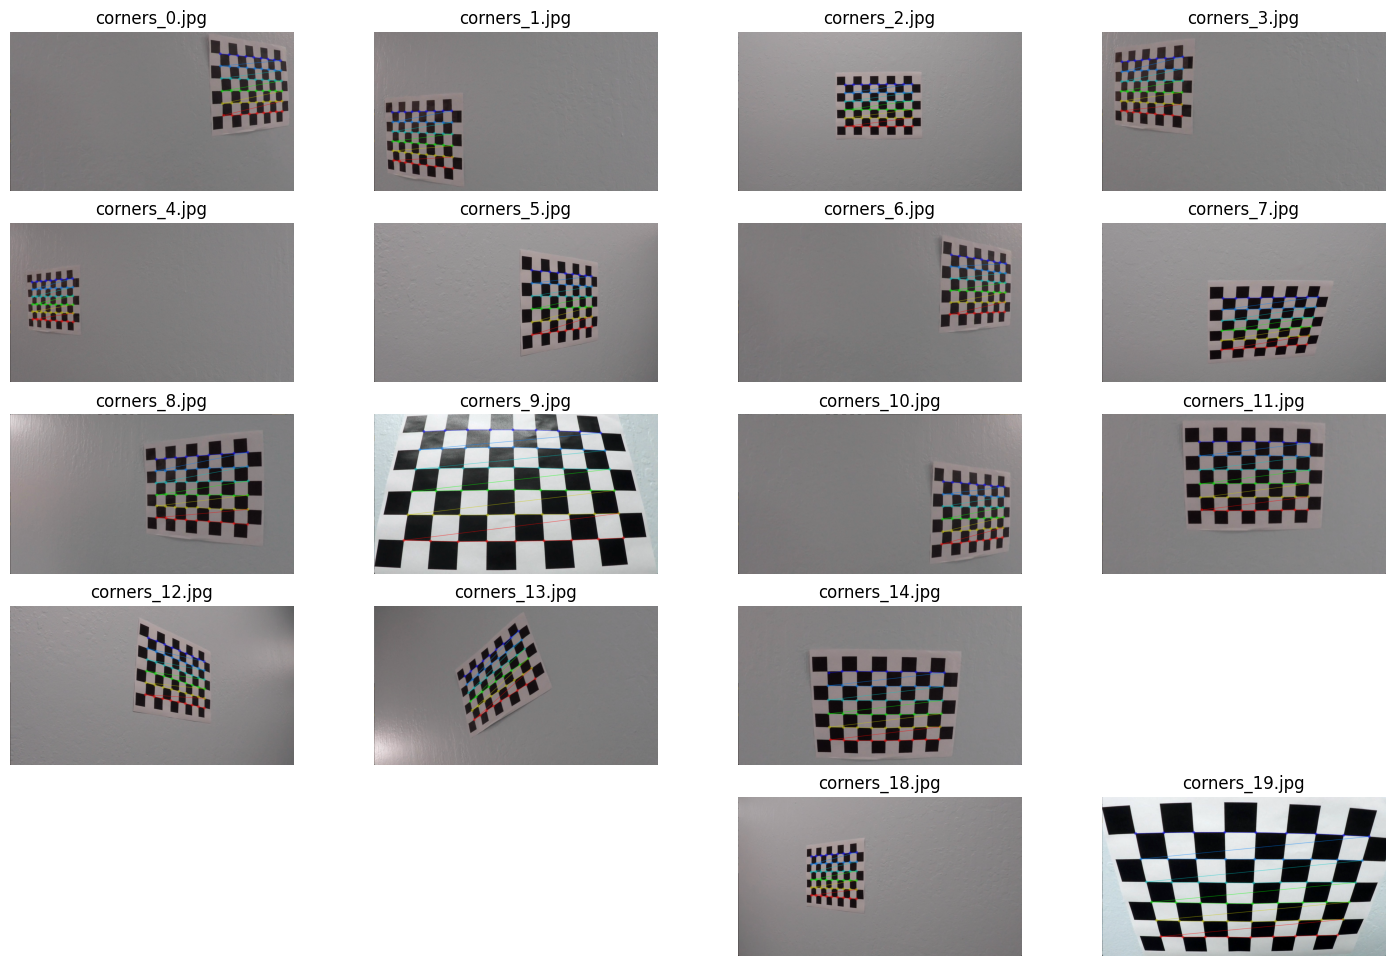

In [7]:
CHECKERBOARD = (6,9)
objp = np.zeros((CHECKERBOARD[0]*CHECKERBOARD[1],3), np.float32)
objp[:,:2] = np.mgrid[0:CHECKERBOARD[1], 0: CHECKERBOARD[0]].T.reshape(-1,2)
objpoints = []
imgpoints = []

images = glob.glob("/content/gdrive/MyDrive/CV Project Data/camera_calib_data/calibration*.jpg")
plt.figure(figsize = (18,12))
grid = gridspec.GridSpec(5,4)
count = 0
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (CHECKERBOARD[1], CHECKERBOARD[0]), None)
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        img = cv2.drawChessboardCorners(img, (CHECKERBOARD[1], CHECKERBOARD[0]), corners, ret)
        write_file_name = 'corners_' + str(idx) + '.jpg'
        img_plt = plt.subplot(grid[count])
        plt.axis('on')
        img_plt.set_xticklabels([])
        img_plt.set_yticklabels([])
        #img_plt.set_aspect('equal')
        plt.imshow(img)
        plt.title(write_file_name)
        plt.axis('off')
    count+=1
plt.show()

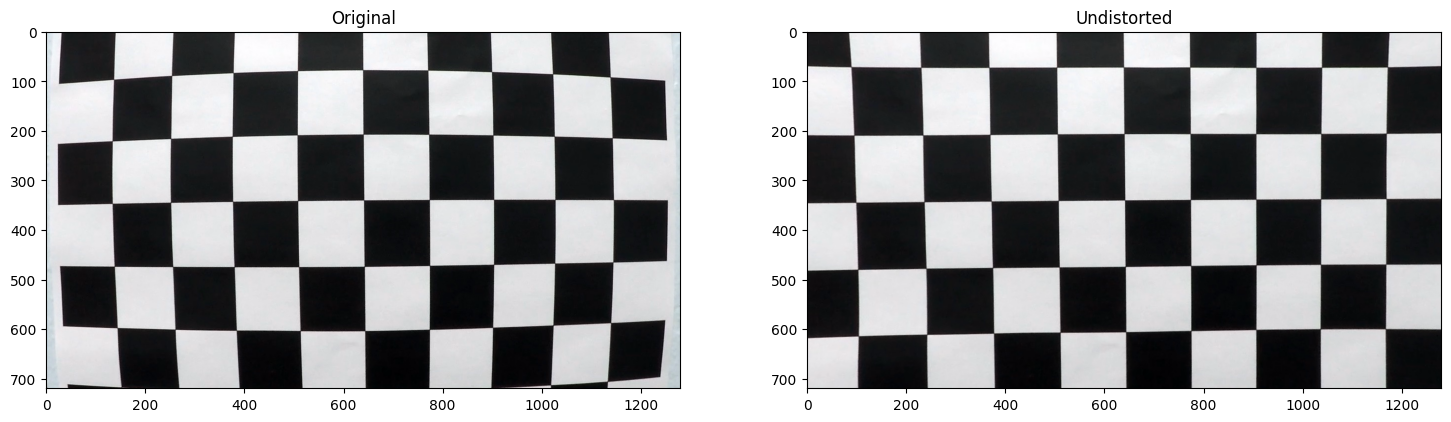

In [8]:
image = cv2.imread("/content/gdrive/MyDrive/CV Project Data/camera_calib_data/calibration1.jpg")
img_size = (image.shape[1], image.shape[0])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

calib_pickle = {}
calib_pickle["matrix"] = mtx
calib_pickle["distortion"] = dist
pickle.dump(calib_pickle, open("calibration_pickle.p", "wb"))

undistorted = cv2.undistort(image, mtx, dist, None, mtx)
plt.figure(figsize = (18,12))
grid = gridspec.GridSpec(1,2)

plot_idx = plt.subplot(grid[0])
plt.imshow(image)
plt.title("Original")
plot_idx = plt.subplot(grid[1])
plt.imshow(undistorted)
plt.title("Undistorted")
plt.show()

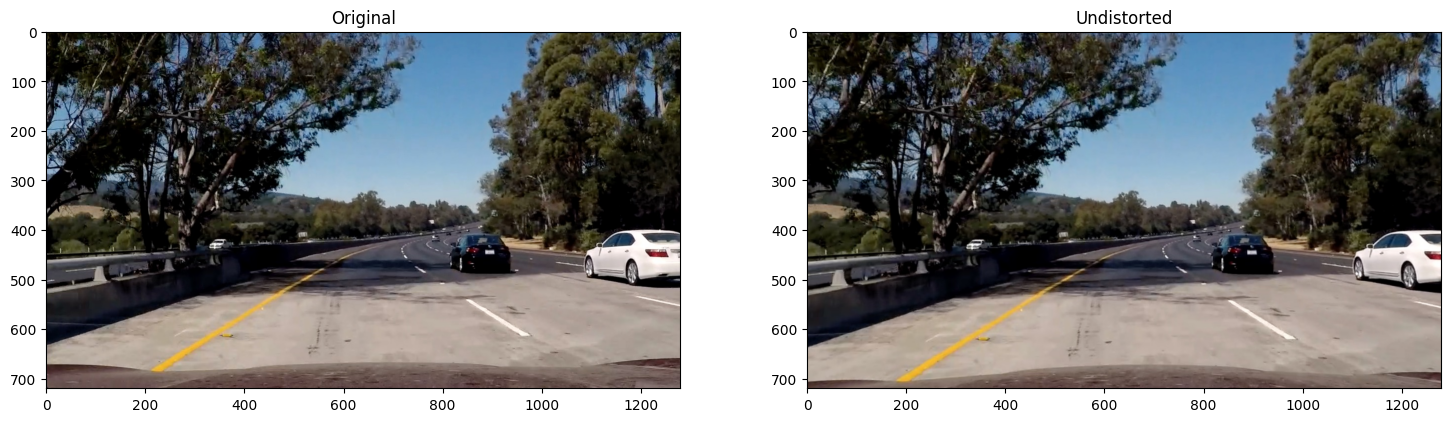

In [9]:
carImg = cv2.imread("/content/gdrive/MyDrive/CV Project Data/test_images/test5.jpg")
carImg = cv2.cvtColor(carImg, cv2.COLOR_BGR2RGB)

undistorted = cv2.undistort(carImg, mtx, dist, None, mtx)

plt.figure(figsize = (18,12))
grid = gridspec.GridSpec(1,2)

plot_idx = plt.subplot(grid[0])
plt.imshow(carImg)
plt.title("Original")
plot_idx = plt.subplot(grid[1])
plt.imshow(undistorted)
plt.title("Undistorted")
plt.show()

**Preprocessing**

In [10]:
def abs_sobel_thresh(img, orient='x', thresh_min=25, thresh_max=255):
    # Convert to grayscale
    # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(l_channel, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(l_channel, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

In [11]:
def color_threshold(image, sthresh=(0,255), vthresh=(0,255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > sthresh[0]) & (s_channel <= sthresh[1])] = 1

    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel > vthresh[0]) & (v_channel <= vthresh[1])] = 1

    output = np.zeros_like(s_channel)
    output[(s_binary == 1) & (v_binary) == 1] = 1

    # Return the combined s_channel & v_channel binary image
    return output

In [19]:
images = glob.glob("/content/gdrive/MyDrive/CV Project Data/test_images/test*.jpg")
print(len(images))
gidx = 0

for idx,fname in enumerate(images):
    #read in image
    img = cv2.imread(fname)
    #undistort the image
    img = cv2.undistort(img,mtx,dist,None,mtx)
    
    #pass image thru the pipeline
    preprocessImage = np.zeros_like(img[:,:,0])
    gradx = abs_sobel_thresh(img, orient='x', thresh_min=50, thresh_max=255)
    grady = abs_sobel_thresh(img, orient='y', thresh_min=25, thresh_max=255)
    c_binary = color_threshold(img, sthresh=(100,255), vthresh=(50,255))
    preprocessImage[((gradx == 1) & (grady ==1) | (c_binary == 1))] = 255
    
    plt.figure(figsize = (18,12))
    grid = gridspec.GridSpec(1,2)

    # set the spacing between axes.
    grid.update(wspace=0.1, hspace=0.1)  

    plt.subplot(grid[0])
    plt.imshow(img, cmap="gray")
    plt.title('Undistorted Image')

    plt.subplot(grid[1])
    plt.imshow(preprocessImage, cmap="gray")
    plt.title('After image processing pipeline')


    # img_size = (img.shape[1],img.shape[0])

    # bot_width = .76 # percentage of bottom trapezoidal height
    # mid_width = .08 # percentage of mid trapezoidal height
    # height_pct = .62 # percentage of trapezoidal height
    # bottom_trim= .935 # percentage from top to bottom avoiding the hood of the car

    # src = np.float32([[img.shape[1]*(0.5-mid_width/2), img.shape[0]*height_pct],[img.shape[1]*(0.5+mid_width/2),img.shape[0]*height_pct],[img.shape[1]*(0.5+bot_width/2), img.shape[0]*bottom_trim],[img.shape[1]*(0.5-bot_width/2), img.shape[0]*bottom_trim]])
    # offset = img_size[0]*0.25
    # dst = np.float32([[offset,0],[img_size[0]-offset,0],[img_size[0]-offset,img_size[1]],[offset,img_size[1]]])
    
    # #perform the warp perspective transform
    # M = cv2.getPerspectiveTransform(src,dst)
    # Minv = cv2.getPerspectiveTransform(dst,src)
    # warped = cv2.warpPerspective(preprocessImage,M,img_size,flags=cv2.INTER_LINEAR)

    # #Visualize the results before/after warping for a birds-eye view along with the source & destination co-ordinate locations
    # plt.figure(figsize = (30,20))
    # grid = gridspec.GridSpec(8,2)
    # # set the spacing between axes.
    # grid.update(wspace=0.05, hspace=0.05)  

    # plt.subplot(grid[gidx])
    # plt.imshow(img, cmap="gray")
    # for i in range(4):
    #     plt.plot(src[i][0],src[i][1],'rs')
    # plt.title('Undistorted Image')

    # plt.subplot(grid[gidx+1])
    # plt.imshow(warped, cmap="gray")
    # for i in range(4):
    #     plt.plot(dst[i][0],dst[i][1],'rs')
    # plt.title('Birds eye view')

plt.show()

Output hidden; open in https://colab.research.google.com to view.

Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)



6


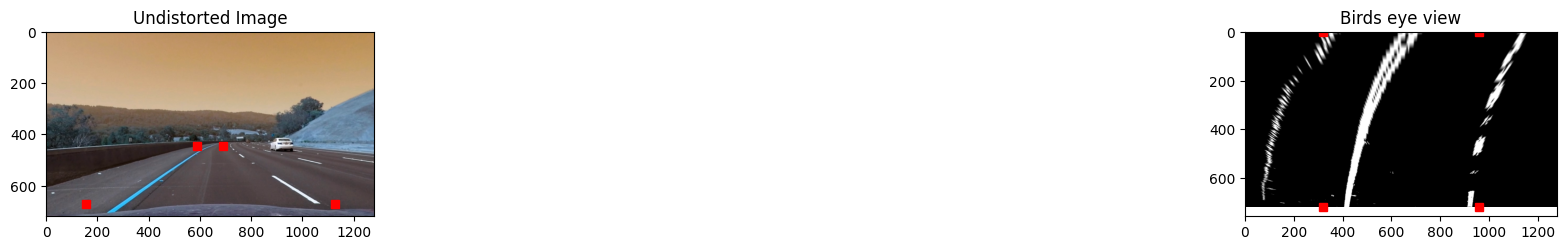

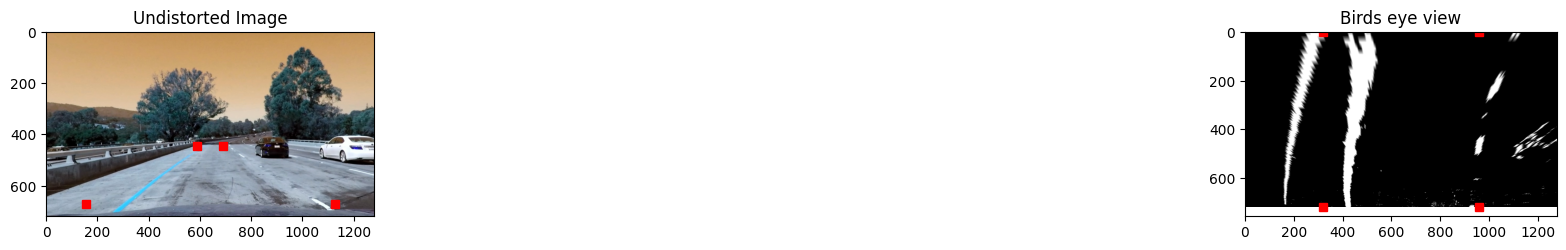

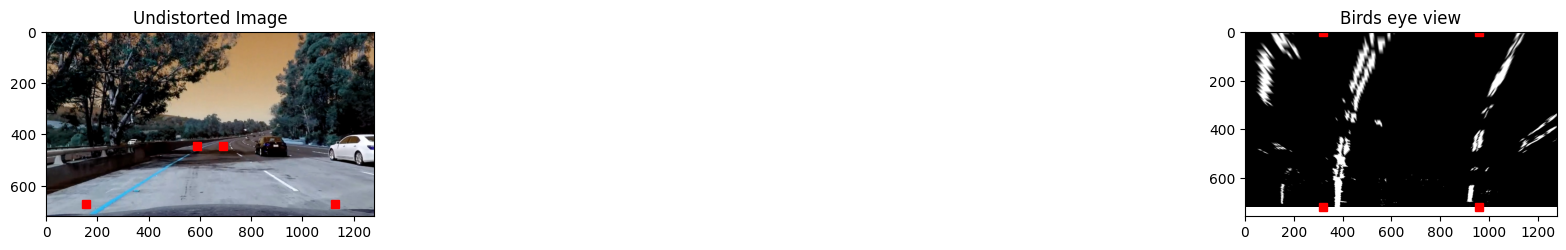

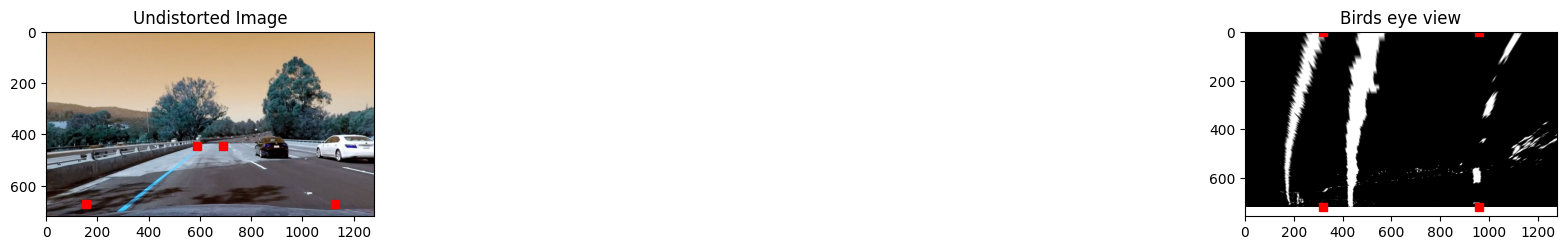

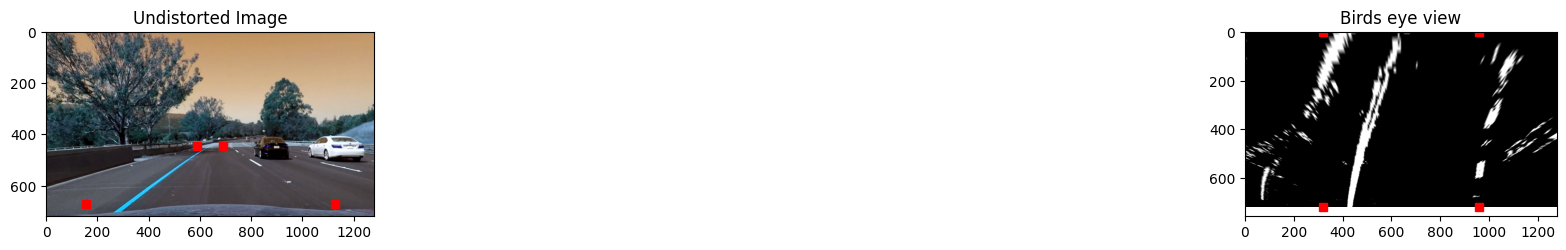

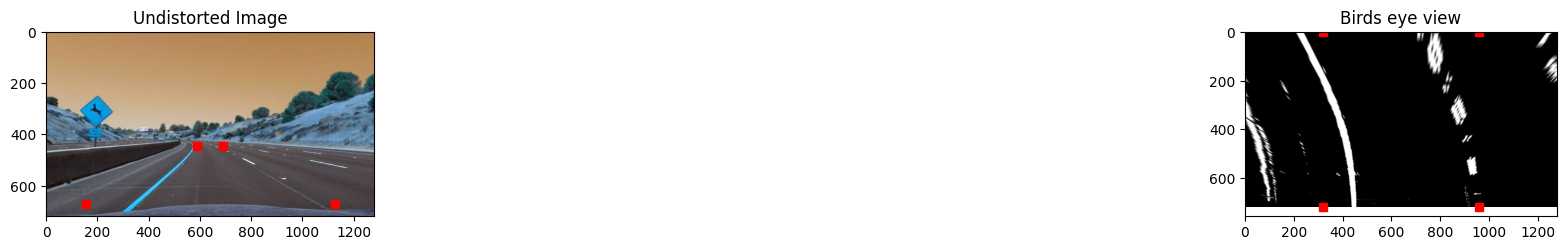

In [33]:
images = glob.glob("/content/gdrive/MyDrive/CV Project Data/test_images/test*.jpg")
print(len(images))
gidx = 0

for idx,fname in enumerate(images):
    #read in image
    img = cv2.imread(fname)

    #undistort the image
    img_size = (img.shape[1],img.shape[0])
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, img_size, 0, img_size)
    img = cv2.undistort(img,newcameramtx,dist,None,newcameramtx)
    
    #pass image thru the pipeline
    preprocessImage = np.zeros_like(img[:,:,0])
    gradx = abs_sobel_thresh(img, orient='x', thresh_min=15, thresh_max=255)
    grady = abs_sobel_thresh(img, orient='y', thresh_min=25, thresh_max=255)
    c_binary = color_threshold(img, sthresh=(100,255), vthresh=(50,255))
    preprocessImage[((gradx == 1) & (grady ==1) | (c_binary == 1))] = 255

    

    bot_width = .76 # percentage of bottom trapezoidal height
    mid_width = .08 # percentage of mid trapezoidal height
    height_pct = .62 # percentage of trapezoidal height
    bottom_trim= .935 # percentage from top to bottom avoiding the hood of the car

    src = np.float32([[img.shape[1]*(0.5-mid_width/2), img.shape[0]*height_pct],[img.shape[1]*(0.5+mid_width/2),img.shape[0]*height_pct],[img.shape[1]*(0.5+bot_width/2), img.shape[0]*bottom_trim],[img.shape[1]*(0.5-bot_width/2), img.shape[0]*bottom_trim]])
    offset = img_size[0]*0.25
    dst = np.float32([[offset,0],[img_size[0]-offset,0],[img_size[0]-offset,img_size[1]],[offset,img_size[1]]])
    
    #perform the warp perspective transform
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(preprocessImage,M,img_size,flags=cv2.INTER_LINEAR)

    #Visualize the results before/after warping for a birds-eye view along with the source & destination co-ordinate locations
    plt.figure(figsize = (30,20))
    grid = gridspec.GridSpec(8,2)
    # set the spacing between axes.
    grid.update(wspace=0.05, hspace=0.05)  

    plt.subplot(grid[gidx])
    plt.imshow(img, cmap="gray")
    for i in range(4):
        plt.plot(src[i][0],src[i][1],'rs')
    plt.title('Undistorted Image')

    plt.subplot(grid[gidx+1])
    plt.imshow(warped, cmap="gray")
    for i in range(4):
        plt.plot(dst[i][0],dst[i][1],'rs')
    plt.title('Birds eye view')

plt.show()